In [1108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
# import pysal
from sklearn import tree
from sklearn.decomposition import pca
from scipy.linalg import lstsq

In [836]:
# merge puma codes with sub-bourough data
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')

In [995]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
3701,gross_rent_adj,"Median rent, all ($2016)",Riverdale/Kingsbridge,1060,1090,1120,1140,1170,1200,1230,1240,1240,1290,1200,1310,1310,BX08,Riverdale/Kingsbridge
3702,gross_rent_adj,"Median rent, all ($2016)",Williamsbridge/Baychester,1000,1070,1100,1110,1120,1160,1150,1190,1200,1240,1220,1210,1250,BX12,Williamsbridge/Baychester
3703,gross_rent_adj,"Median rent, all ($2016)",Throgs Neck/Co-op City,950,990,1050,1020,1140,1070,1130,1150,1020,1110,1130,1070,1200,BX10,Throgs Neck/Co-op City
3704,gross_rent_adj,"Median rent, all ($2016)",Pelham Parkway,1000,1080,1040,1130,1080,1130,1140,1180,1200,1160,1240,1260,1270,BX11,Pelham Parkway
3705,gross_rent_adj,"Median rent, all ($2016)",Morrisania/Belmont,690,810,850,870,870,910,900,930,900,940,910,960,970,BX03BX06,Morrisania/Belmont


In [838]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes['2005'] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

puma
3709                   Soundview/Parkchester
3801               Washington Heights/Inwood
4014                            Borough Park
3708              Highbridge/South Concourse
3803                          Central Harlem
4101                                 Astoria
4015                                Flatbush
3705                      Morrisania/Belmont
4008             East New York/Starrett City
4006    North Crown Heights/Prospect Heights
3802    Morningside Heights/Hamilton Heights
4001                 Williamsburg/Greenpoint
3707              University Heights/Fordham
3706             Kingsbridge Heights/Moshulu
3710                  Mott Haven/Hunts Point
3809               Lower East Side/Chinatown
3804                             East Harlem
4007                  Brownsville/Ocean Hill
4011                     South Crown Heights
4018                            Coney Island
4003                      Bedford Stuyvesant
4002                                Bushwick
Name:

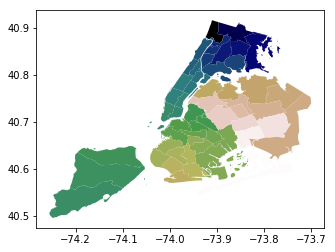

In [839]:
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
sbas.plot(cmap='gist_earth')
plt.show()

In [840]:
sbas = sbas.merge(puma_cd_name, on='puma')

In [841]:
puma_cd['cd'] = puma_cd['cd'].str.replace(" ", "")
sbas['cd'] = sbas['cd'].str.replace(" ","")

In [842]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)

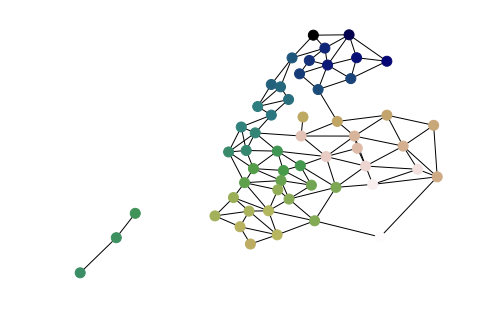

In [843]:
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

In [844]:
years = ['2000'] + [str(y) for y in range(2005,2017)]
columns = ['cd'] + years
# neighbor_mean = np.zeros(len(sbas.index), len(years))
# moransi = np.zeros(len(sbas.index), len(years))
mean_rents = median_rents.mean()
neighbor_means = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    mean_row = rent_rows.mean()
    mean_row['puma'] = puma
    neighbor_means = neighbor_means.append(mean_row, ignore_index=True)

In [845]:
neighbor_means['puma'] = neighbor_means['puma'].astype('int64')
neighbor_means = neighbor_means.merge(puma_cd_name, on = 'puma')
neighbor_means = neighbor_means.set_index('puma')

In [846]:
# wmatrix = pysal.weights.WSP(nx.adj_matrix(G))

In [847]:
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [848]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [849]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [850]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [851]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)

In [852]:
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')

In [853]:
subways = subways.dropna(how='any')

In [854]:
subways = subways.set_index('puma')

In [855]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    newrow['Name'] = merged_name[i]
    new_units = new_units.append(newrow, ignore_index = True)

In [856]:
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')

In [857]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)

In [858]:
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')

In [859]:
years = [str(y) for y in range(2005,2017)]
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [860]:
# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

In [1047]:
median_incomes = median_incomes.sort_index()
education_levels = education_levels.sort_index()
percents_white = percents_white.sort_index()
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
subways = subways.sort_index()
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()
crime = crime.sort_index()
neighbor_means = neighbor_means.sort_index()
median_rents = median_rents.sort_index()

In [1062]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, 
                     education_levels[years].values, 
                     percents_white[years].values, 
                     subways[years].values, 
                     new_units[years].values, 
                     crime[years].values, 
                     neighbor_means[years].values, 
                     median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-1,:]
Y_test = Y[:,-1]
Y = Y[:,:-1]
X = Xs[:, :-1, :]
clf = tree.DecisionTreeRegressor()
predictions = np.zeros(k)
resids = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i] = clf.predict(X_test[i,:].reshape(1, -1))

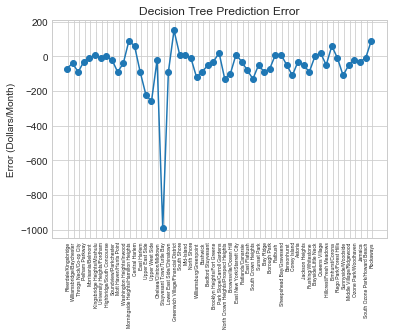

In [1063]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.plot(errs, 'o-')
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
ax.set_title('Decision Tree Prediction Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
plt.ylabel('Error (Dollars/Month)')
plt.show()

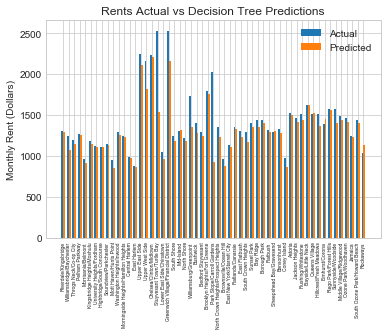

In [1064]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Decision Tree Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [1101]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values, median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-1,:]
Y_test = Y[:,-1]
Y = Y[:,:-1]
X = Xs[:, :-1, :]
clf = linear_model.LinearRegression()
predictions = np.zeros(k)
resids = np.zeros(k)
coeffs = np.zeros((k, m+1))
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i] = clf.predict(X_test[i].reshape(1,-1))[0]
    resids[i] = clf.score(X_test[i].reshape(1,-1), Y_test[i].reshape(1,-1))
    coeffs[i,:] = clf.coef_

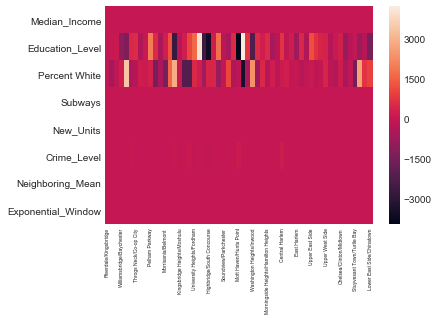

In [1132]:
ax = sns.heatmap((coeffs - np.mean(coeffs, axis = 0)).T)
# coeffs.shape
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.set_yticklabels(['Median_Income', 'Education_Level', 'Percent White', 'Subways', 'New_Units', 'Crime_Level', 'Neighboring_Mean', 'Exponential_Window'], rotation='horizontal')
plt.show()

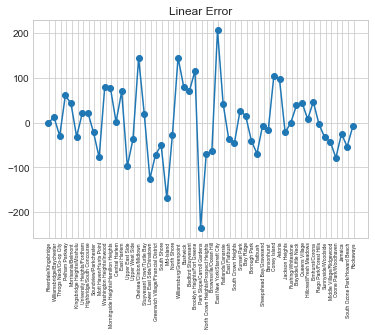

In [1069]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.plot(errs, 'o-')
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
ax.set_title('Linear Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.yaxis.set_label("Monthly Rent (Dollars)")
plt.show()

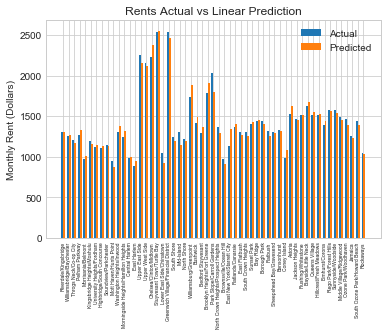

In [1070]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Linear Prediction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [1084]:
colors = sns.cubehelix_palette(8)
colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8822898168737189, 0.695820866705742, 0.7065457119485431],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.7195800708349119, 0.45537982893127477, 0.5861062995810926],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.46496993672552045, 0.26868986121314253, 0.4636527763640647],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

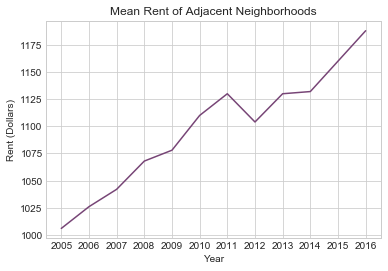

In [1099]:
row = neighbor_means.loc[3702]
plt.plot(years, row[years], color = colors[5])
plt.xlabel('Year')
plt.ylabel('Rent (Dollars)')
plt.title('Mean Rent of Adjacent Neighborhoods')
plt.show()

$$x_i = \frac{1}{N_i}\sum_{j \in n(i)} x_j $$

In [ ]:
$$\frac{N}{W}\frac{}{}